In [ ]:
import pandas as pd
import plotly.express as px

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.tree import export_graphviz
from IPython.display import Image
from subprocess import call
import shap
from xgboost import plot_tree, plot_importance
import geopandas as gpd
from shapely.ops import unary_union
from shapely.geometry import MultiPoint, box


with open('token.txt', 'r') as f:
    TOKEN = f.read()
    px.set_mapbox_access_token(TOKEN)

In [25]:
import geopandas as gpd
from shapely.geometry import MultiPoint, box


In [11]:
comunas = gpd.read_file("../data/Comunas_de_Chile-shp/58fa2d20-ee1c-41ec-9dc6-e2f67a84fb67202041-1-sygnjs.mzdle.shp")
comunas

,FID,region,cut,region_1,ine,comuna,provincia,shape_leng,cont,shape_le_1,shape_area,Shape__Are,Shape__Len,geometry
0,1,12,12401,XII,585,NATALES,ULTIMA ESPERANZA,412.129065,0,412.121384,11089.195943,27287.839844,646.866312,"POLYGON ((-75.44109 -50.52889, -75.44137 -50.5..."
1,2,12,12401,XII,585,NATALES,ULTIMA ESPERANZA,379.507797,0,379.499272,10239.858818,25198.171875,595.399460,"POLYGON ((-75.44315 -50.52910, -75.44339 -50.5..."
2,3,12,12401,XII,585,NATALES,ULTIMA ESPERANZA,414.049313,0,414.040557,12877.658494,31691.058594,649.485445,"POLYGON ((-75.44071 -50.53032, -75.44129 -50.5..."
3,4,12,12401,XII,585,NATALES,ULTIMA ESPERANZA,581.709992,0,581.697282,20096.063953,49457.863281,912.016661,"POLYGON ((-75.44270 -50.53158, -75.44279 -50.5..."
4,5,12,12401,XII,585,NATALES,ULTIMA ESPERANZA,692.384194,0,692.370294,31485.343910,77667.152344,1087.369850,"POLYGON ((-74.83194 -50.56510, -74.83222 -50.5..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10780,10781,12,12401,XII,585,NATALES,ULTIMA ESPERANZA,521.173127,0,521.162832,16134.953688,38003.566406,800.360220,"POLYGON ((-75.40109 -49.47498, -75.40129 -49.4..."
10781,10782,12,12401,XII,585,NATALES,ULTIMA ESPERANZA,726.694395,0,726.681036,28868.411782,67957.761719,1114.253790,"POLYGON ((-75.54520 -49.46704, -75.54533 -49.4..."
10782,10783,12,12401,XII,585,NATALES,ULTIMA ESPERANZA,638.959831,0,638.947867,30677.610183,72249.925781,980.439191,"POLYGON ((-75.44008 -49.47409, -75.44048 -49.4..."
10783,10784,12,12401,XII,585,NATALES,ULTIMA ESPERANZA,579.522246,0,579.512034,19736.325498,46465.148438,889.322804,"POLYGON ((-75.55190 -49.46997, -75.55237 -49.4..."


<Axes: >

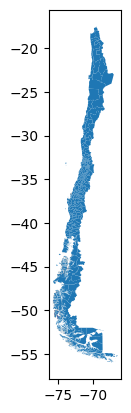

In [13]:
comunas.plot()

In [ ]:
comunas['comuna'].value_counts()

In [ ]:
comunas['provincia'].value_counts()

In [ ]:
comunas[comunas['comuna'] == 'NATALES'].plot()

In [ ]:
comunas[comunas['comuna'] == 'AISEN'].plot()

In [ ]:
comunas[comunas['comuna'] == 'CISNES'].plot()

In [6]:
gdf = gpd.GeoSeries(comunas[comunas['comuna'] == 'CISNES']['geometry'])
union = gdf.unary_union

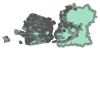

In [7]:
union

In [47]:
# Create a series array with all the points in geometry
cmm = comunas.groupby('comuna').agg({'geometry': lambda x:x.tolist()})
for i, row in cmm.iterrows():
    u = gpd.GeoSeries(row.geometry).unary_union
    cmm.at[i, 'geometry_union'] = u

In [50]:
cmm['geometry_union']

comuna
AISEN              MULTIPOLYGON (((-75.310652875959 -46.846078654...
ALGARROBO          MULTIPOLYGON (((-71.6861686138088 -33.36083214...
ALHUE              POLYGON ((-70.9717354021656 -33.9167886448237,...
ALTO DEL CARMEN    POLYGON ((-69.6908639741927 -28.5928749311104,...
ANCUD              MULTIPOLYGON (((-74.1497346782874 -42.19937955...
                                         ...                        
VITACURA           POLYGON ((-70.5184439449657 -33.3754021718393,...
YERBAS BUENAS      POLYGON ((-71.4291395611858 -35.6112269404826,...
YUMBEL             POLYGON ((-72.6541621088923 -36.9168108814772,...
YUNGAY             POLYGON ((-71.5492989784101 -37.0203201424305,...
ZAPALLAR           MULTIPOLYGON (((-71.2026046850631 -32.60349507...
Name: geometry_union, Length: 341, dtype: object

In [52]:
cmm.drop(columns='geometry', inplace=True)
cmm = gpd.GeoDataFrame(cmm, geometry='geometry_union')

In [55]:
cmm.reset_index(inplace=True)

In [57]:
#export to geojson
cmm.to_file("../data/comunas_union.geojson", driver='GeoJSON')

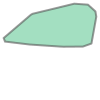

In [8]:
union.convex_hull

In [ ]:
# Merge all the polygons and get the outer region shape
union = unary_union(gdf)
union_hull = union.convex_hull
union_hull.exterior

In [ ]:
# Make a new df with the groupby of comunas and return the union of the polygons
comunas_union = comunas.groupby('comuna').agg({'geometry': lambda x: unary_union(x).convex_hull})

In [ ]:
comunas_union.reset_index(inplace=True)

In [ ]:
comunas_union['geometry'].plot()

In [ ]:
comunas_union.reset_index(inplace=True)

In [ ]:
comunas_union['comuna'].dtype, comunas_union['geometry'].dtype

In [ ]:
comunas_union.set_geometry('geometry', inplace=True)

In [ ]:
#comunas_union.to_file('../data/comunas_union.geojson', driver='GeoJSON')

In [ ]:
wildfires = pd.read_parquet('../data/fires_merged.parquet')

In [ ]:
fires = wildfires.sample(5000)

### This approach for 500k points uses 60mins

In [ ]:
%%time
from shapely.geometry import Point

def find_comuna(row, comunas_df):
    #result = []
    point = Point(row['longitude'], row['latitude'])
    for i, row in comunas_df.iterrows():
        if point.within(row['geometry']):
            return row['comuna']
    return None

fires['comuna'] = fires.apply(find_comuna, axis=1, args=(comunas_union,))

### How to improve it in case I have to use it again.

- We could use some kind of hashmap based on the pattern that Chile is a long country so basically we only have to filter the points based on distance .

In [ ]:
# y is the latitude
comunas_union.geometry.centroid.y.sort_values()

In [ ]:
selection = fires.sample(10)[['latitude', 'longitude', 'comuna']]
selection

In [ ]:
val = int(selection.iloc[0]['latitude'])
val

In [ ]:
# My strategy would be indexing all the comunas by the first digits of latitude, and the search from there between the possible collissions.
hash_map_comunas = {}
for i, row in comunas_union.iterrows():
    lat = int(row['geometry'].centroid.y)
    if lat not in hash_map_comunas:
        hash_map_comunas[lat] = []
    hash_map_comunas[lat].append(row)
hash_map_comunas

In [ ]:
hash_map_comunas[float(Decimal('-31.8'))]

In [ ]:
# Verify if we indexed correctly the Comuna
def index_comuna(row, comunas_df):
    lat = float(Decimal(str(row['latitude'])).quantize(Decimal('0.0'), rounding=ROUND_DOWN))
    point = Point(row['longitude'], row['latitude'])
    for comuna in hash_map_comunas[lat]:
        if point.within(comunas_df[comunas_df['comuna'] == comuna].iloc[0]['geometry']):
            return comuna
    return None

selection['comuna_indexed'] = selection.apply(index_comuna, axis=1, args=(comunas_union,))